# **Analysis of the NTU RGB+D Action Recognition Dataset**

___
___

## **1. Initialization**

### *1.1. Import*

In [1]:
from IPython.display import display
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns;

from torch.utils.data import Dataset

import torch

In [2]:
# to fill the requirement.txt file we use the following line of code:
# import session_info
# session_info.show()

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. Data Loading*

In [4]:
data2D_dir = "data/nturgbd60_skeletons_2D/"
data3D_dir = "data/nturgbd60_skeletons_3D/"

data2D_files = os.listdir(data2D_dir)
data3D_files = os.listdir(data3D_dir)

In [5]:
with open("data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [6]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [7]:
class HumanActionDataset(Dataset):

    """
    inputs:
    - (str) data_type: type of the dataset to build either '2D' or '3D'.
    - (str) data_dir: path to the data folder of the data (either 2D or 3D) to consider.
    - (list) data_files: name of the files in the folder to consider.
    - (list) classes: id of the classes to consider.
    """

    def __init__(self, data_type:str='2D', data_dir:str=data2D_dir, data_files:list=data2D_files, classes:list=classes):
        self.data_type = data_type
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.data_type == '2D':
            tensor = tensor.reshape((tensor.shape[0], 50))
        else:
            tensor = tensor.reshape((tensor.shape[0], 75))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [8]:
HAD2D = HumanActionDataset('2D', data2D_dir, data2D_files, classes)
HAD3D = HumanActionDataset('3D', data3D_dir, data3D_files, classes)

___

## **2. Analysis**

### *2.1. Number of Frames*

In [10]:
frames_info_2D = [(i, HAD2D[i][0].shape[0], HAD2D[i][1]) for i in tqdm(range(len(HAD2D)))]
frames_info_2D = pd.DataFrame(data=frames_info_2D, columns=["id", "nb_frames", "action_class"])
frames_info_2D = frames_info_2D.set_index("id")

100%|██████████| 8491/8491 [04:03<00:00, 34.91it/s]  


In [11]:
frames_info_2D_stats = [frames_info_2D[frames_info_2D["action_class"] == i].describe()["nb_frames"] for i in range(len(classes))]
frames_info_2D_stats = pd.DataFrame(frames_info_2D_stats, index = range(len(classes)))

For a given action class:
* ***count**: number of sample*
* ***mean**: mean number of frames*
* ***std**: standard deviation*
* ***min**: minimum number of frames*
* ***25%**: 1st quartile for the number of frames*
* ***50%**: median number of frames*
* ***75%**: 3rd quartile for the number of frames*
* ***max**: maximum number of frames*

In [12]:
display(frames_info_2D_stats.round().astype(int).style.hide_index())

count,mean,std,min,25%,50%,75%,max
943,81,14,54,72,81,90,131
944,64,13,37,55,62,71,136
941,74,14,46,65,74,83,119
936,64,12,39,55,63,71,120
945,141,34,66,117,138,159,277
946,97,23,54,82,94,109,202
944,56,12,32,49,54,63,110
946,64,14,36,54,62,71,128
946,64,12,40,56,62,70,139


### *2.2. Occupation of Space*

In this part we will see, for each action class, what part of the space is mostly used and where on the screen the action are most likely to be located.

In [13]:
HAD2D[0][0].shape

torch.Size([75, 50])

In [14]:
# for a better visualization we will decrease the scale of the map by 10
heatmap2D = np.zeros((len(classes),25,192,108))

for i in tqdm(range(len(HAD2D))):
    tensor2D,label2D = HAD2D[i]
    for j in range(tensor2D.shape[0]):
        for k in range(25):
            x = tensor2D[:,2*k][j].item()
            y = tensor2D[:,2*k+1][j].item()
            if np.isnan(x) or np.isnan(y):
                pass
            else:
                x = min(max(0,int(x/10)),192)-1
                y = min(max(0,int(y/10)),108)-1
                heatmap2D[label2D][k][x][y] += 1

100%|██████████| 8491/8491 [04:29<00:00, 31.46it/s]


<Figure size 432x288 with 0 Axes>

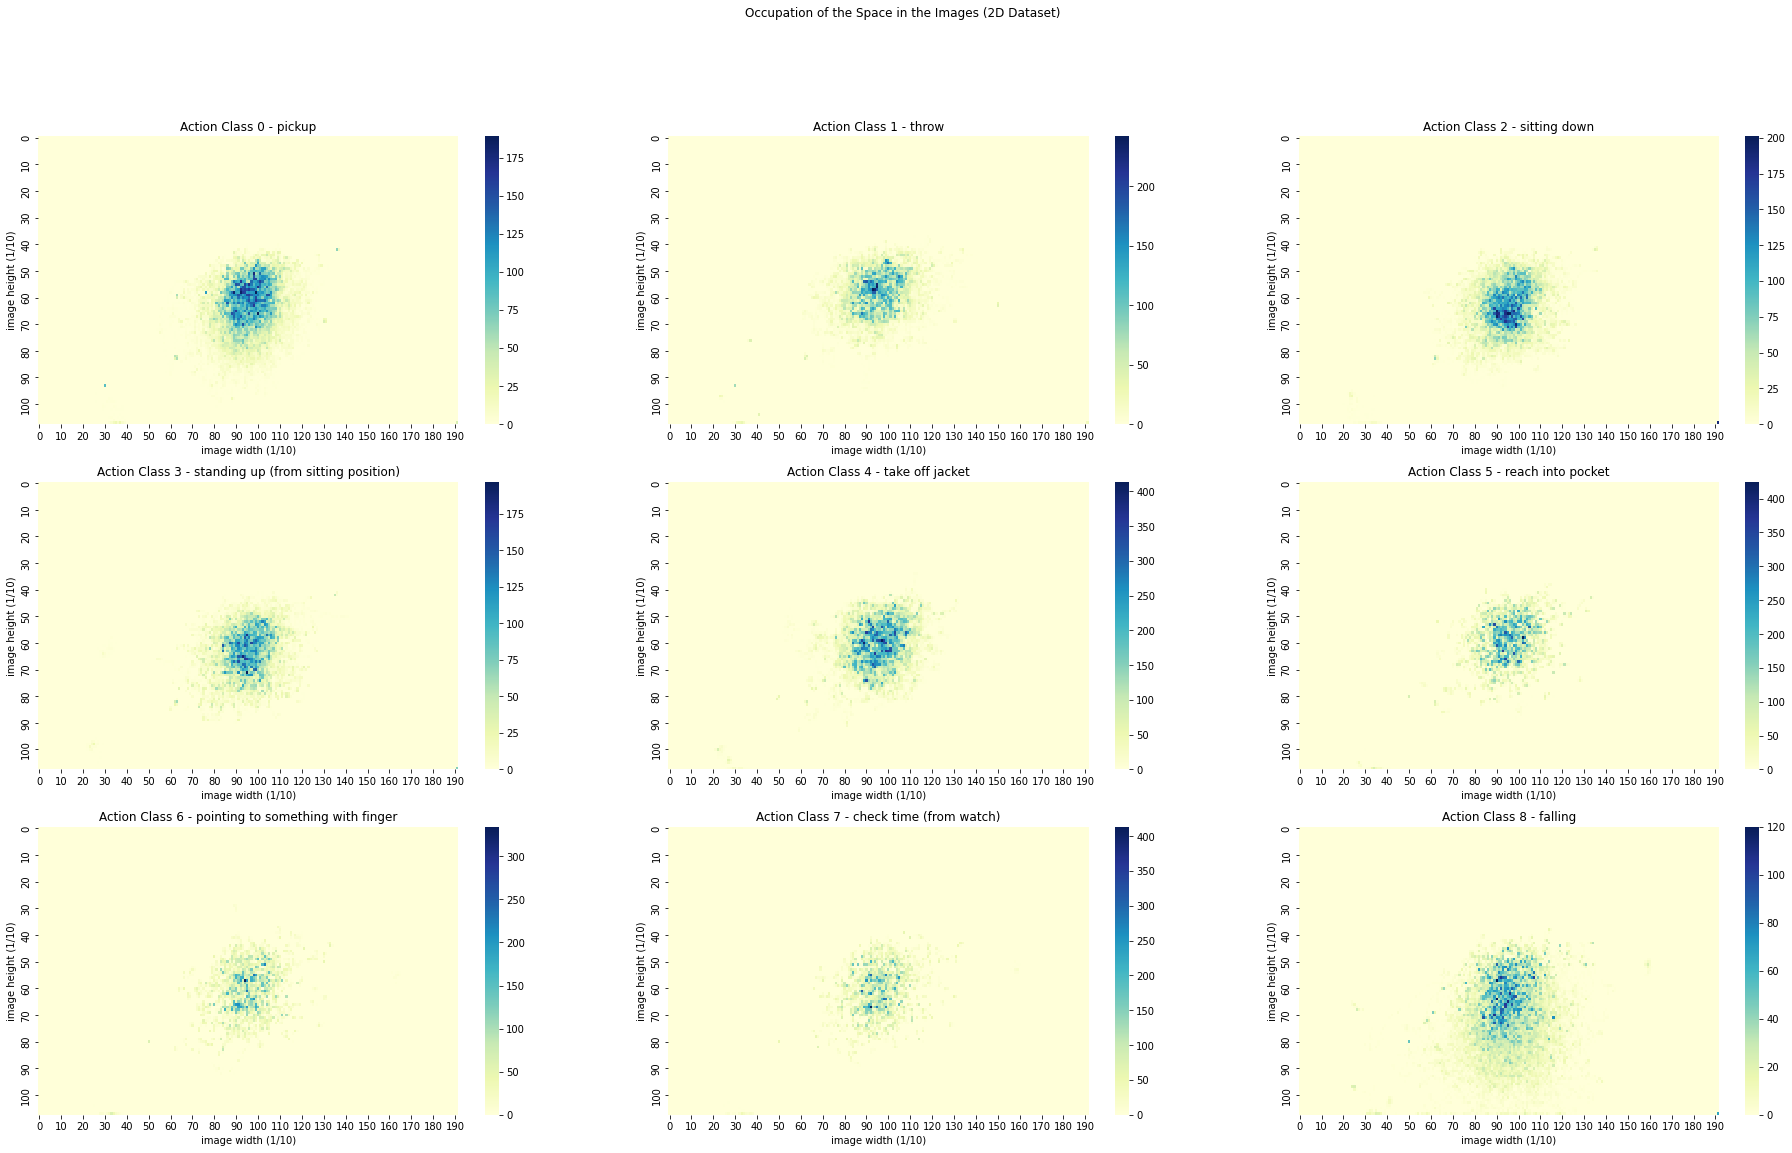

In [15]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    h = sns.heatmap(heatmap2D[i][0].transpose(), cmap="YlGnBu", cbar=True, ax=ax[i//3][i%3], xticklabels=10, yticklabels=10)
    h.set_xlabel("image width (1/10)")
    h.set_ylabel("image height (1/10)")

fig.suptitle("Occupation of the Space in the Images (2D Dataset)")
plt.show()

In [16]:
distrib2D = [{"x": [], "y": []} for i in range(len(classes))]

for i in tqdm(range(len(HAD2D))):
    tensor2D,label2D = HAD2D[i]
    for j in range(tensor2D.shape[0]):
        for k in range(25):
            x = tensor2D[:,2*k][j].item()
            y = tensor2D[:,2*k+1][j].item()
            if np.isnan(x) or np.isnan(y):
                pass
            else:
                x = min(max(0,int(x/10)),192)-1
                y = min(max(0,int(y/10)),108)-1
                distrib2D[label2D]["x"].append(x)
                distrib2D[label2D]["y"].append(y)

distrib2D_df = [pd.DataFrame(distrib2D[i]) for i in range(len(classes))]

100%|██████████| 8491/8491 [04:17<00:00, 33.02it/s]


<Figure size 432x288 with 0 Axes>

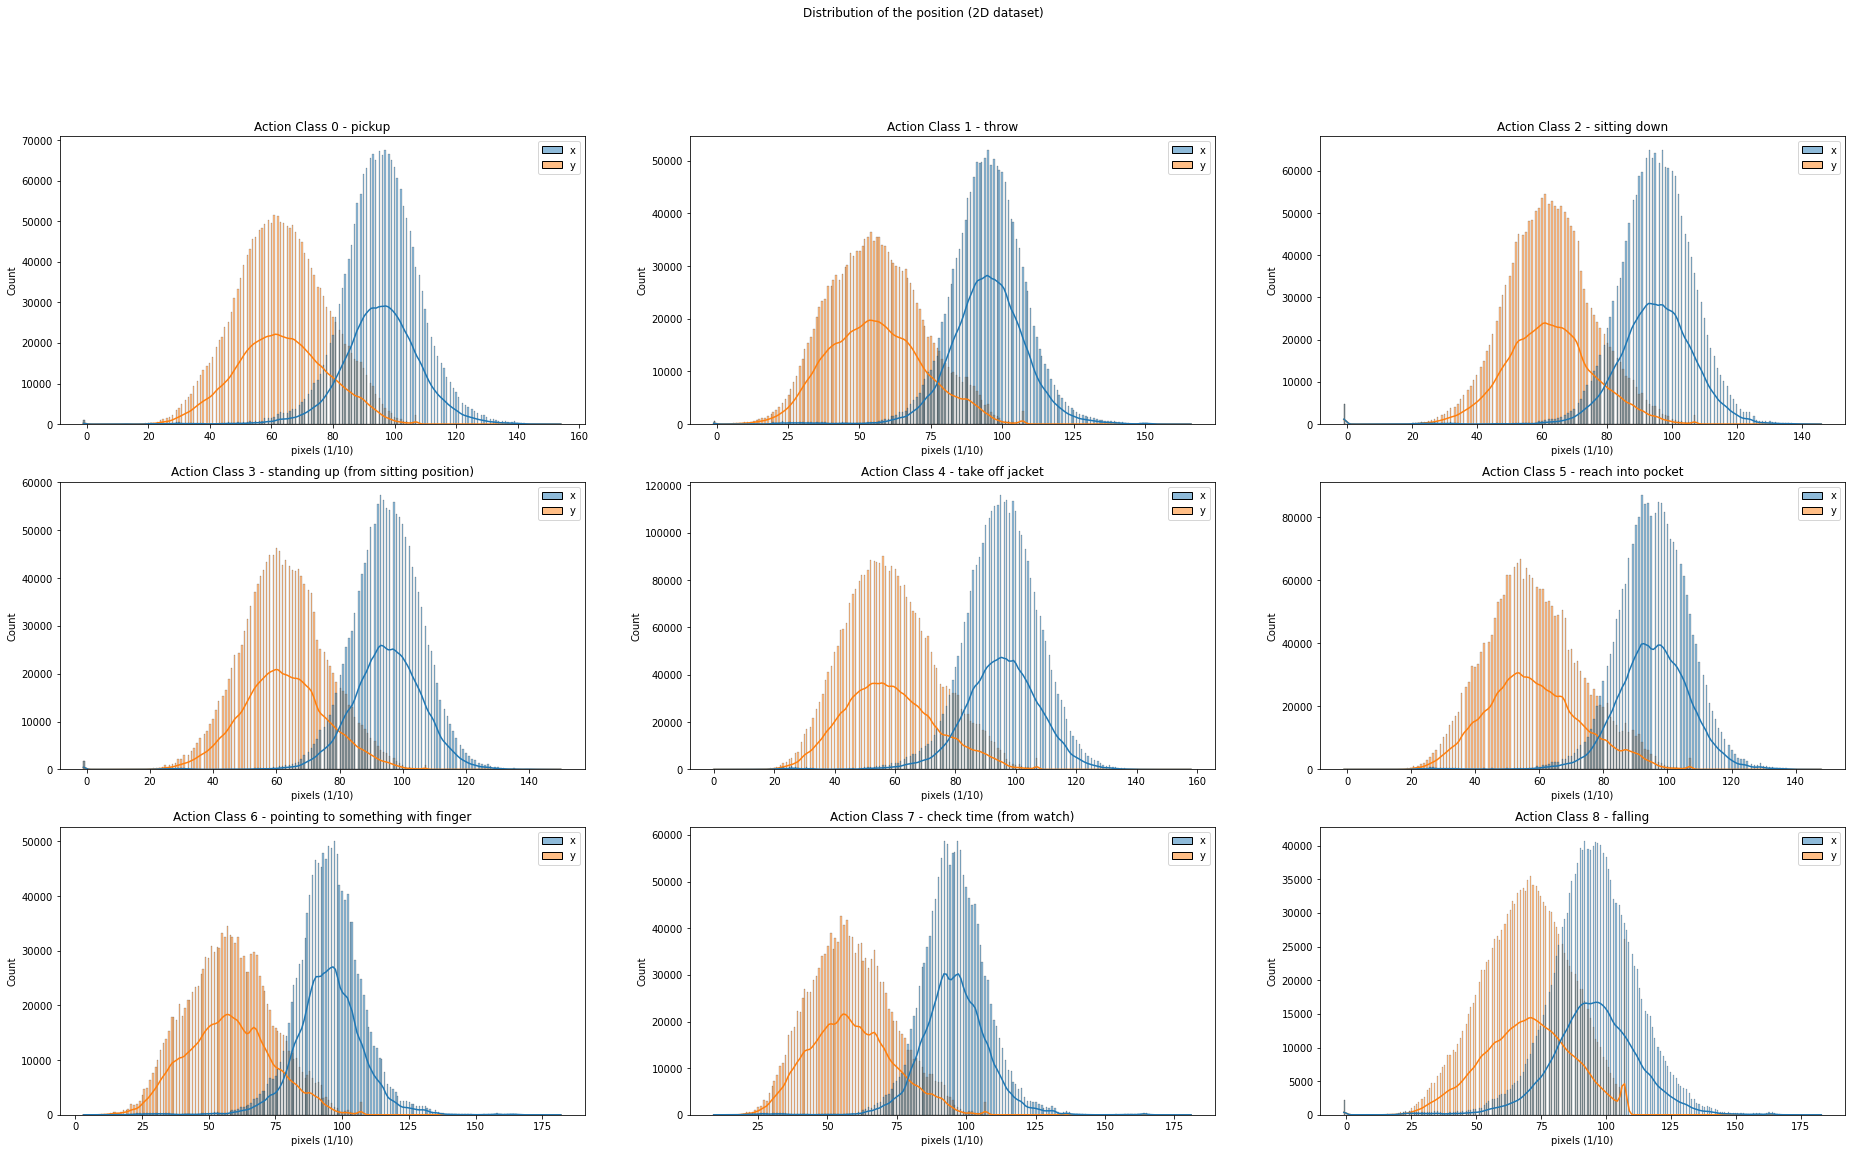

In [17]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    h = sns.histplot(data=distrib2D_df[i], ax=ax[i//3][i%3], kde=True)
    h.set_xlabel("pixels (1/10)")

fig.suptitle("Distribution of the position (2D dataset)")
plt.show()

In [18]:
distrib3D = [{"x": [], "y": [], "z": []} for i in range(len(classes))]

for i in tqdm(range(len(HAD3D))):
    tensor3D,label3D = HAD3D[i]
    for j in range(tensor3D.shape[0]):
        for k in range(25):
            x = tensor3D[:,3*k][j].item()
            y = tensor3D[:,3*k+1][j].item()
            z = tensor3D[:,3*k+2][j].item()
            # to delete some outliers manually (we could have also considered the quantiles)
            if np.isnan(x) or np.isnan(y) or np.isnan(z) or (x < -2) or (y < -2) or (z < -2):
                pass
            else:
                distrib3D[label3D]["x"].append(x)
                distrib3D[label3D]["y"].append(y)
                distrib3D[label3D]["z"].append(z)

distrib3D_df = [pd.DataFrame(distrib3D[i]) for i in range(len(classes))]

100%|██████████| 8491/8491 [09:56<00:00, 14.25it/s]


<Figure size 432x288 with 0 Axes>

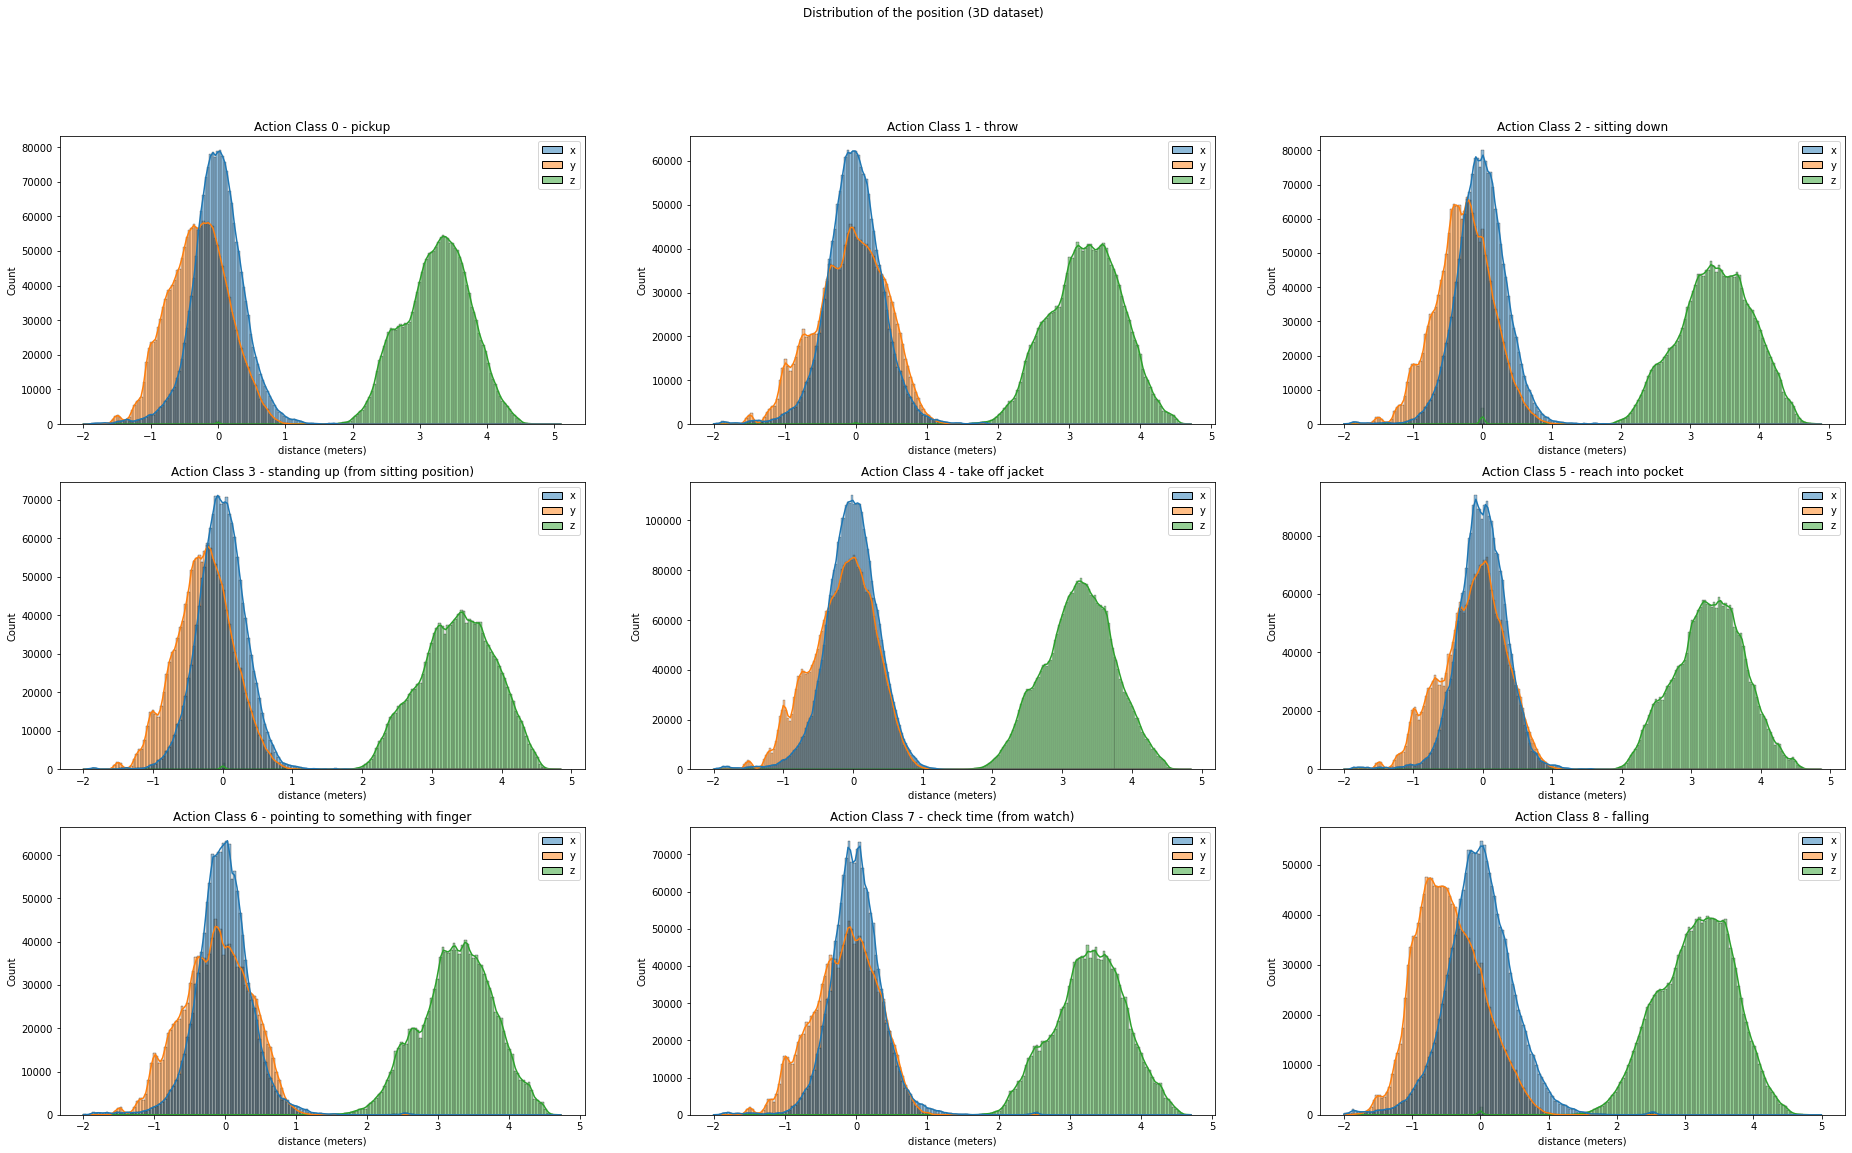

In [19]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    h = sns.histplot(data=distrib3D_df[i], ax=ax[i//3][i%3], kde=True)
    h.set_xlabel("distance (meters)")

fig.suptitle("Distribution of the position (3D dataset)")
plt.show()

### *2.3. Correlation between 2D and 3D data*

In [26]:
x2D,x3D,y2D,y3D = [],[],[],[]

for i in tqdm(range(len(HAD2D)//2)):
    tensor2D,label2D = HAD2D[i]
    tensor3D,label3D = HAD3D[i]
    for j in range(tensor2D.shape[0]):
        for k in range(25):
            x2 = tensor2D[:,2*k][j].item()
            y2 = tensor2D[:,2*k+1][j].item()
            x3 = tensor3D[:,3*k][j].item()
            y3 = tensor3D[:,3*k+1][j].item()
            x2 = min(max(0,int(x2)),1920)
            y2 = min(max(0,int(y2)),1080)
            x2D.append(x2)
            y2D.append(y2)
            x3D.append(x3)
            y3D.append(y3)

x2D,x3D,y2D,y3D = np.array(x2D),np.array(x3D),np.array(y2D),np.array(y3D)

100%|██████████| 4245/4245 [03:10<00:00, 22.29it/s]


(Pearson) Correlation between $x$ in 2D and in 3D:

In [30]:
abs(np.corrcoef(x2D,x3D)[0][1])

0.9648566827282936

(Pearson) Correlation between $y$ in 2D and in 3D:

In [31]:
abs(np.corrcoef(y2D,y3D)[0][1])

0.9707711949318295

We notice a strong (positive) correlation for $x$ and a strong (negative) correlation for $y$. Can we obtain one value (2D) to the other (3D) using a simple model (such as linear regression) ?

In [23]:
train_size = 0.9

X2D_train = x2D[:int(train_size*len(x2D))].reshape((-1, 1))
X3D_train = x3D[:int(train_size*len(x2D))].reshape((-1, 1))
X2D_test = x2D[int(train_size*len(x2D)):].reshape((-1, 1))
X3D_test = x3D[int(train_size*len(x2D)):].reshape((-1, 1))

Y2D_train = y2D[:int(train_size*len(y2D))].reshape((-1, 1))
Y3D_train = y3D[:int(train_size*len(y2D))].reshape((-1, 1))
Y2D_test = y2D[int(train_size*len(y2D)):].reshape((-1, 1))
Y3D_test = y3D[int(train_size*len(y2D)):].reshape((-1, 1))

modelX = LinearRegression()
modelY = LinearRegression()

modelX.fit(X2D_train, X3D_train)
modelY.fit(Y2D_train, Y3D_train)

print("train size: {}\ntest  size:  {}\n".format(int(train_size*len(x2D)),len(x2D)-int(train_size*len(x2D))))

print("[x] train acc: {}\n[x] test acc:  {}\n\n[y] train acc: {}\n[y] test  acc: {}".format(
    modelX.score(X2D_train, X3D_train).round(3),
    modelX.score(X2D_test, X3D_test).round(3),
    modelY.score(Y2D_train, Y3D_train).round(3),
    modelY.score(Y2D_test, Y3D_test).round(3)))

train size: 7707127
test  size:  856348

[x] train acc: 0.936
[x] test acc:  0.871

[y] train acc: 0.947
[y] test  acc: 0.901


In [24]:
pkl.dump(modelX, open("./models_saved/regX.sav", 'wb'))
pkl.dump(modelY, open("./models_saved/regY.sav", 'wb'))

___
___